In [1]:
import sys

sys.path.append("..")
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from dory.classifier import (
    GaussianNaiveBayesClassifier,
    GaussianDiscriminatorAnalysisClassifier,
    SoftmaxRegressionClassifier,
)
from dory.cross_validators import DoryKFoldCrossValidator
import logging

logging.basicConfig(level=logging.INFO)

In [2]:
df = pd.read_csv("vehicle.csv", header=None)
df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.00000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000
mean,93.678487,44.861702,82.088652,168.940898,61.693853,8.567376,168.839243,40.933806,20.582742,147.998818,188.625296,439.911348,174.70331,72.462175,6.377069,12.599291,188.932624,195.632388,1.469267
std,8.234474,6.169866,15.771533,33.472183,7.888251,4.601217,33.244978,7.811560,2.592138,14.515652,31.394837,176.692614,32.54649,7.486974,4.918353,8.931240,6.163949,7.438797,1.111905
min,73.000000,33.000000,40.000000,104.000000,47.000000,2.000000,112.000000,26.000000,17.000000,118.000000,130.000000,184.000000,109.00000,59.000000,0.000000,0.000000,176.000000,181.000000,0.000000
25%,87.000000,40.000000,70.000000,141.000000,57.000000,7.000000,146.250000,33.000000,19.000000,137.000000,167.000000,318.250000,149.00000,67.000000,2.000000,5.000000,184.000000,190.250000,0.000000
50%,93.000000,44.000000,80.000000,167.000000,61.000000,8.000000,157.000000,43.000000,20.000000,146.000000,178.500000,364.000000,173.00000,71.500000,6.000000,11.000000,188.000000,197.000000,1.000000
75%,100.000000,49.000000,98.000000,195.000000,65.000000,10.000000,198.000000,46.000000,23.000000,159.000000,217.000000,587.000000,198.00000,75.000000,9.000000,19.000000,193.000000,201.000000,2.000000
max,119.000000,59.000000,112.000000,333.000000,138.000000,55.000000,265.000000,61.000000,29.000000,188.000000,320.000000,1018.000000,268.00000,135.000000,22.000000,41.000000,206.000000,211.000000,3.000000


In [3]:
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42069
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(676, 18) (170, 18) (676,) (170,)


In [4]:
logger = logging.getLogger("CrossValidation")

classifiers = [
    ("Gaussian Naive Bayes", GaussianNaiveBayesClassifier()),
    ("Gaussian Discriminant Analysis", GaussianDiscriminatorAnalysisClassifier()),
    (
        "Softmax Regression",
        SoftmaxRegressionClassifier(learning_rate=0.01, epochs=1000),
    ),
]

results = {
    name: {
        "global_accuracy": [],
        "accuracy_per_class": [],
        "mean_global_accuracy": 0,
        "std_global_accuracy": 0,
        "mean_accuracy_per_class": {},
        "std_accuracy_per_class": {},
    }
    for name, _ in classifiers
}

n_folds = 10
random_state = 42069

cv = DoryKFoldCrossValidator(n_splits=n_folds, random_state=random_state, shuffle=True)

for i, (train_index, test_index) in enumerate(cv.split(X)):
    logger.debug(f"Fold {i}:")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for name, clf in classifiers:
        clf.fit(X_train, y_train)

        accuracy = clf.score(X_test, y_test)

        accuracy_per_class = {clz: [] for clz in np.unique(y)}

        for clz in np.unique(y):
            y_test_clz = y_test[y_test == clz]
            y_pred_clz = clf.predict(X_test[y_test == clz])
            class_accuracy = np.mean(y_pred_clz == y_test_clz)

            accuracy_per_class[clz].append(class_accuracy)

        results[name]["accuracy_per_class"].append(accuracy_per_class)
        results[name]["global_accuracy"].append(accuracy)

        logger.debug(
            f"classifier {name}, Accuracy: {accuracy:.4f}, Accuracy per class: {accuracy_per_class}, Fold {i + 1}/{n_folds}"
        )


for name, _ in classifiers:
    global_accuracies = results[name]["global_accuracy"]
    mean_global_accuracy = np.mean(global_accuracies)
    std_global_accuracy = np.std(global_accuracies)

    results[name]["mean_global_accuracy"] = mean_global_accuracy
    results[name]["std_global_accuracy"] = std_global_accuracy

    logger.info(
        f"Classifier {name} - Global Accuracy: Mean={mean_global_accuracy:.4f}, Std={std_global_accuracy:.4f}"
    )

    accuracy_per_class = results[name]["accuracy_per_class"]
    mean_accuracy_per_class = {}
    std_accuracy_per_class = {}

    for clz in np.unique(y):
        class_accuracies = [fold_acc[clz][0] for fold_acc in accuracy_per_class]
        mean_accuracy_per_class[clz] = np.mean(class_accuracies)
        std_accuracy_per_class[clz] = np.std(class_accuracies)

    results[name]["mean_accuracy_per_class"] = mean_accuracy_per_class
    results[name]["std_accuracy_per_class"] = std_accuracy_per_class

    logger.info(
        f"Classifier {name} - Accuracy per class: Mean={mean_accuracy_per_class}, Std={std_accuracy_per_class}"
    )

INFO:CrossValidation:Classifier Gaussian Naive Bayes - Global Accuracy: Mean=0.4517, Std=0.0679
INFO:CrossValidation:Classifier Gaussian Naive Bayes - Accuracy per class: Mean={np.float64(0.0): np.float64(0.15627489177489176), np.float64(1.0): np.float64(0.4021679758860065), np.float64(2.0): np.float64(0.4034251782838739), np.float64(3.0): np.float64(0.8917175763692793)}, Std={np.float64(0.0): np.float64(0.07364150459491588), np.float64(1.0): np.float64(0.09527930059957822), np.float64(2.0): np.float64(0.12316581071295526), np.float64(3.0): np.float64(0.06163466907209628)}
INFO:CrossValidation:Classifier Gaussian Discriminant Analysis - Global Accuracy: Mean=0.7694, Std=0.0383
INFO:CrossValidation:Classifier Gaussian Discriminant Analysis - Accuracy per class: Mean={np.float64(0.0): np.float64(0.9433575036075036), np.float64(1.0): np.float64(0.6087885430852182), np.float64(2.0): np.float64(0.5782017483321831), np.float64(3.0): np.float64(0.9483156042443968)}, Std={np.float64(0.0): np.f

In [5]:
summary_data = []
class_mapper = {
    0.0: "Opel",
    1.0: "Saab",
    2.0: "Bus",
    3.0: "Van",
}

for name, _ in classifiers:
    row = {
        "Classificador": name,
        "Acurácia Global (Média)": f"{results[name]['mean_global_accuracy']:.4f}",
        "Acurácia Global (DP)": f"{results[name]['std_global_accuracy']:.4f}",
    }

    for clz in sorted(np.unique(y)):
        class_name = class_mapper[float(clz)]
        row[f"Classe {class_name} (Média)"] = (
            f"{results[name]['mean_accuracy_per_class'][clz]:.4f}"
        )
        row[f"Classe {class_name} (DP)"] = (
            f"{results[name]['std_accuracy_per_class'][clz]:.4f}"
        )

    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
display(summary_df)

,Classificador,Acurácia Global (Média),Acurácia Global (DP),Classe Opel (Média),Classe Opel (DP),Classe Saab (Média),Classe Saab (DP),Classe Bus (Média),Classe Bus (DP),Classe Van (Média),Classe Van (DP)
0,Gaussian Naive Bayes,0.4517,0.0679,0.1563,0.0736,0.4022,0.0953,0.4034,0.1232,0.8917,0.0616
1,Gaussian Discriminant Analysis,0.7694,0.0383,0.9434,0.0416,0.6088,0.0838,0.5782,0.1251,0.9483,0.0399
2,Softmax Regression,0.3652,0.0741,0.2008,0.3014,0.3121,0.4090,0.5203,0.4217,0.4504,0.3192


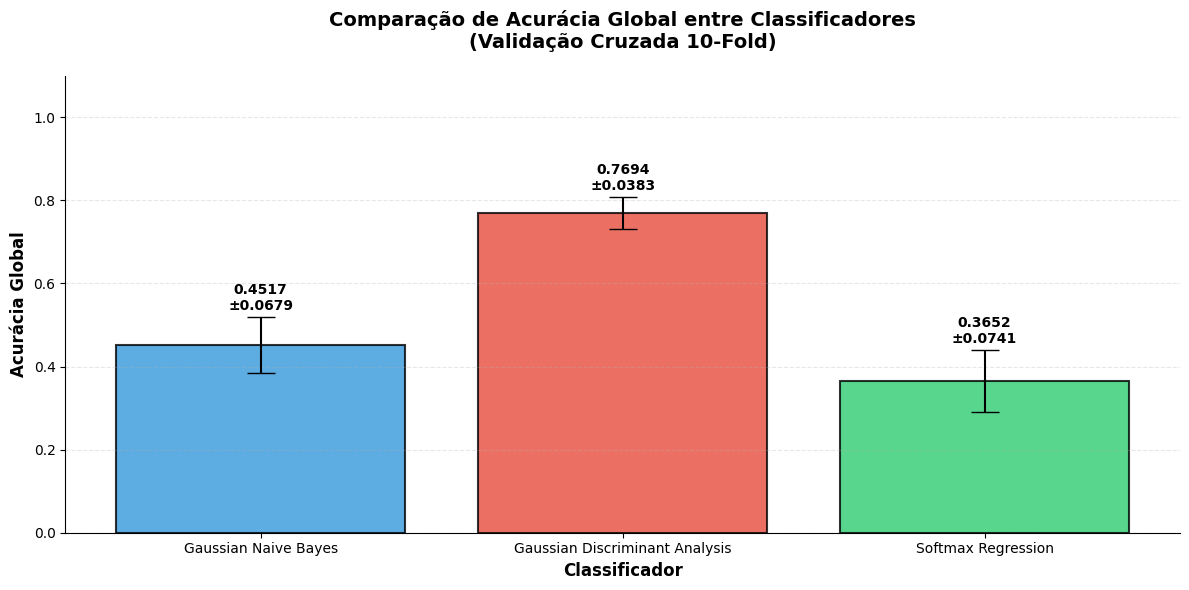

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))

classifier_names = [name for name, _ in classifiers]
means = [results[name]["mean_global_accuracy"] for name, _ in classifiers]
stds = [results[name]["std_global_accuracy"] for name, _ in classifiers]

colors = ["#3498db", "#e74c3c", "#2ecc71"]
bars = ax.bar(
    classifier_names,
    means,
    yerr=stds,
    capsize=10,
    color=colors,
    alpha=0.8,
    edgecolor="black",
    linewidth=1.5,
)

for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + std + 0.01,
        f"{mean:.4f}\n±{std:.4f}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )

ax.set_ylabel("Acurácia Global", fontsize=12, fontweight="bold")
ax.set_xlabel("Classificador", fontsize=12, fontweight="bold")
ax.set_title(
    f"Comparação de Acurácia Global entre Classificadores\n(Validação Cruzada {n_folds}-Fold)",
    fontsize=14,
    fontweight="bold",
    pad=20,
)
ax.set_ylim(0, 1.1)
ax.grid(axis="y", alpha=0.3, linestyle="--")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

In [7]:
from sklearn.metrics import confusion_matrix

# Recarregar os dados para ter X_train e X_test limpos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42069
)

# Armazenar predições e matrizes de confusão
confusion_matrices = {}

for name, clf in classifiers:
    # Treinar no conjunto completo de treino
    clf.fit(X_train, y_train)

    # Fazer predições no conjunto de teste
    y_pred = clf.predict(X_test)

    # Calcular matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices[name] = {
        "matrix": cm,
        "y_pred": y_pred,
        "accuracy": np.mean(y_pred == y_test),
    }

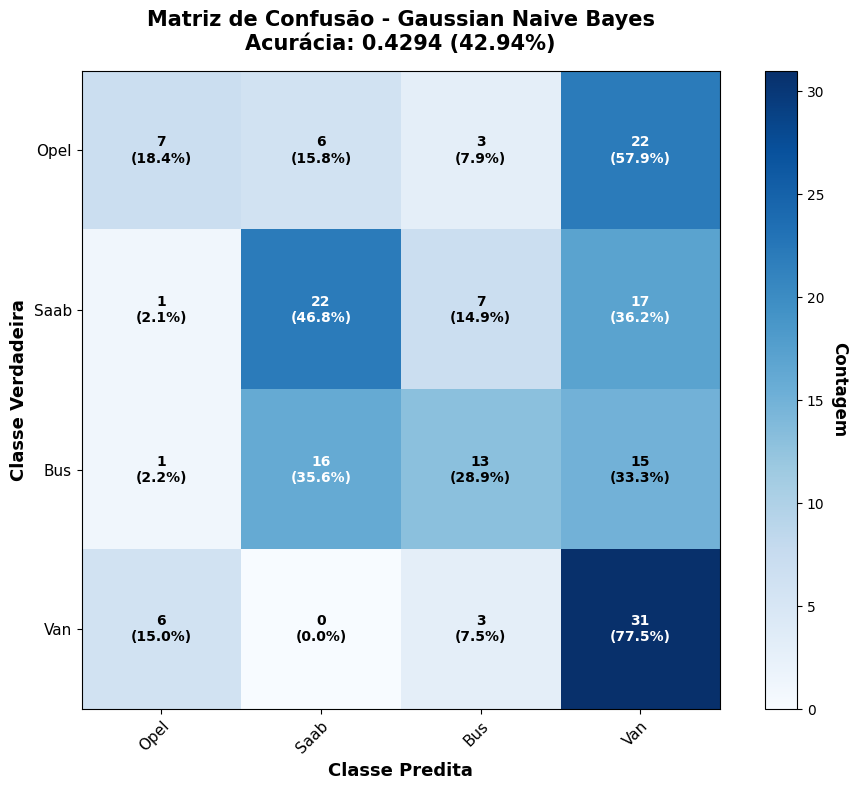

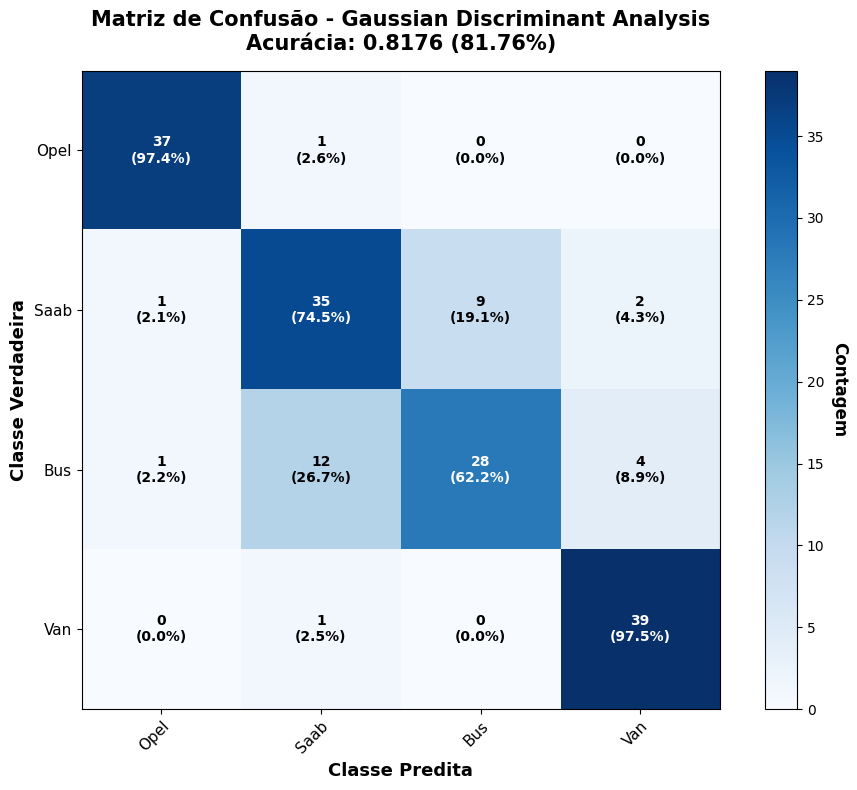

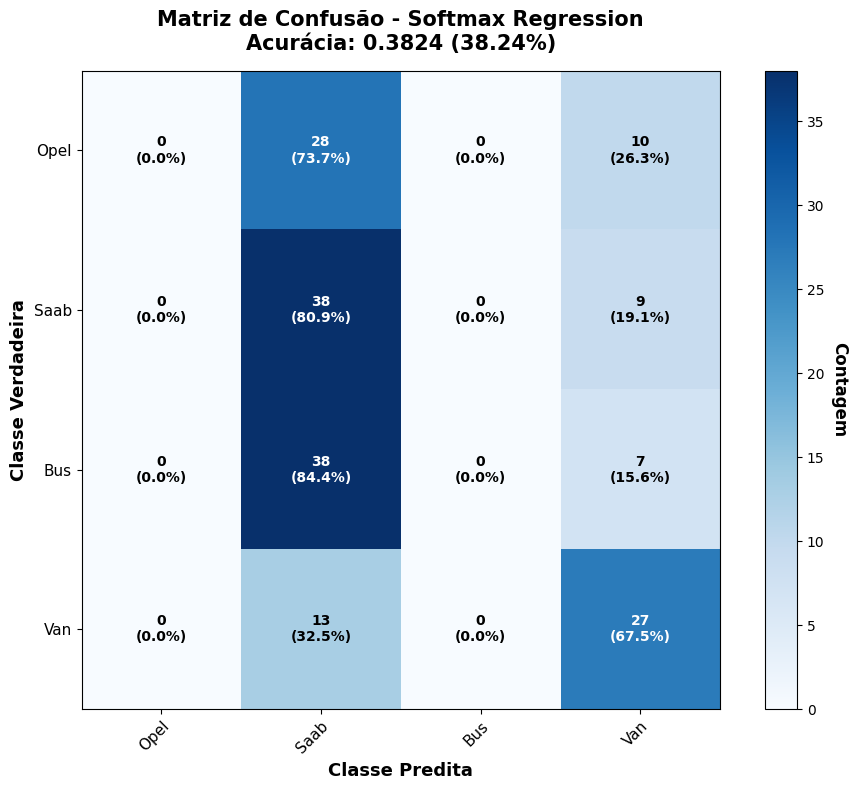

In [8]:
# Matrizes de confusão individuais (maiores e mais detalhadas)
for name, _ in classifiers:
    fig, ax = plt.subplots(figsize=(10, 8))
    cm = confusion_matrices[name]["matrix"]

    # Criar heatmap
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")

    # Colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel(
        "Contagem", rotation=-90, va="bottom", fontsize=12, fontweight="bold"
    )

    # Configurar classes
    classes_list = sorted(np.unique(y))
    class_names = [class_mapper[float(clz)] for clz in classes_list]

    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names, fontsize=11)
    ax.set_yticklabels(class_names, fontsize=11)

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Adicionar valores e porcentagens
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            percentage = cm[i, j] / cm[i].sum() * 100
            text = f"{cm[i, j]}\n({percentage:.1f}%)"
            ax.text(
                j,
                i,
                text,
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=10,
                fontweight="bold",
            )

    # Labels
    ax.set_ylabel("Classe Verdadeira", fontsize=13, fontweight="bold")
    ax.set_xlabel("Classe Predita", fontsize=13, fontweight="bold")

    accuracy = confusion_matrices[name]["accuracy"]
    ax.set_title(
        f"Matriz de Confusão - {name}\nAcurácia: {accuracy:.4f} ({accuracy * 100:.2f}%)",
        fontsize=15,
        fontweight="bold",
        pad=15,
    )

    plt.tight_layout()
    plt.show()